In [120]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [121]:
def get_train(X_train, fname):
    for i in range(1,6):
        fname_cur = fname + str(i)
        vals = np.load('train/'+fname_cur+".npy")
        X_train = np.concatenate((X_train, vals), axis = 1)
    return X_train

In [122]:
def get_test(X_test, fname):
    vals = np.load('test/'+fname+"1t.npy")
    X_test = np.concatenate((X_test, vals), axis = 1)
    return X_test

In [123]:
# Get train data
X_train = np.zeros(shape=[114,1])
X_train = get_train(X_train, 'walking_')
X_train = get_train(X_train, 'running_')
X_train = get_train(X_train, 'jumping_')
X_train = X_train[:,1:]

In [124]:
# Get test data
X_test = np.zeros(shape=[114,1])
X_test = get_test(X_test, 'walking_')
X_test = get_test(X_test, 'running_')
X_test = get_test(X_test, 'jumping_')
X_test = X_test[:,1:]

In [125]:
# Centralize X_train and compute PCA
def compute_SVD(X):
    X_center = X - np.mean(X, axis = 1)[:, None]
    dU, ds, dVt = np.linalg.svd(X_center)
    return dU, ds, dVt

In [126]:
dU, ds, dVt = compute_SVD(X_train)

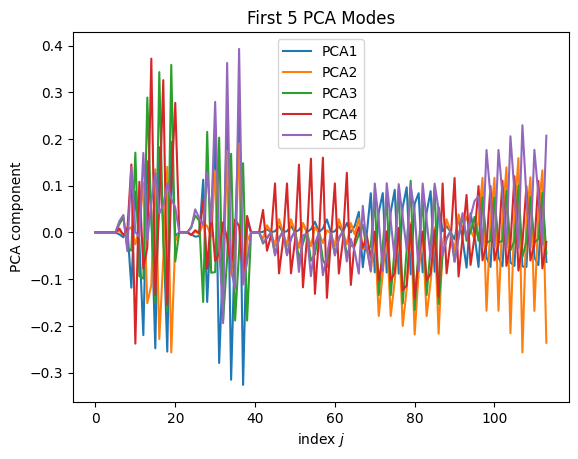

In [127]:
fig1 = plt.figure(1)
ax1 = plt.axes()
for i in range(5):
    ax1.plot(np.arange(0, 114), dU_train[:, i], label = 'PCA'+str(i+1))
plt.legend()
plt.xlabel('index $j$')
plt.ylabel('PCA component')
plt.title('First 5 PCA Modes')
fig1.savefig('figure1.pdf', bbox_inches='tight')

In [128]:
def find_modes(E, target):
    percentage = 0
    for i in range(len(E)):
        percentage += E[i]
        if percentage >= target:
            return i+1, percentage

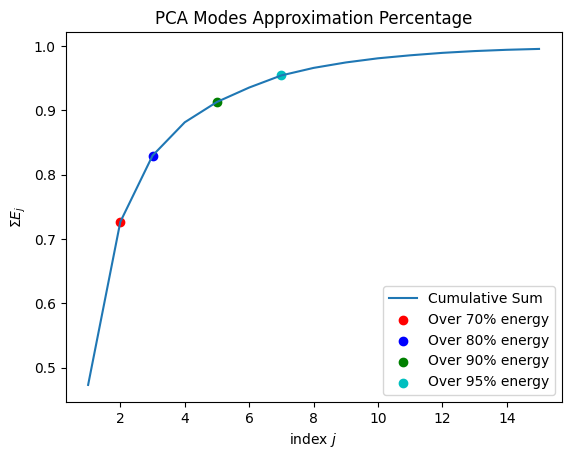

In [129]:
# Find appropriate PCA nodes to approximate X_train
E = np.power(ds_train, 2)/np.sum(np.power(ds_train,2))
pca_70, percentage_70 = find_modes(E, 0.7)
pca_80, percentage_80 = find_modes(E, 0.8)
pca_90, percentage_90 = find_modes(E, 0.9)
pca_95, percentage_95 = find_modes(E, 0.95)
number_pca = [pca_70, pca_80, pca_90, pca_95]
percentage_pca = [percentage_70, percentage_80, percentage_90, percentage_95]
fig2 = plt.figure(2)
ax2 = plt.axes()
ax2.plot(np.arange(1, 16), np.cumsum(E)[:15], label = 'Cumulative Sum')
#ax2.scatter(number_pca, percentage_pca, c='r')
ax2.scatter(pca_70, percentage_70, c = 'r', label = 'Over 70% energy')
ax2.scatter(pca_80, percentage_80, c = 'b', label = 'Over 80% energy')
ax2.scatter(pca_90, percentage_90, c = 'g', label = 'Over 90% energy')
ax2.scatter(pca_95, percentage_95, c = 'c', label = 'Over 95% energy')
ax2.legend()
plt.xlabel('index $j$')
plt.ylabel('$\Sigma E_j$')
plt.title('PCA Modes Approximation Percentage')
fig2.savefig('figure2.pdf', bbox_inches='tight')

In [130]:
def pca_project(dU, X, components):
    dU_approx = dU[:,:components]
    X_approx = np.dot(np.transpose(dU_approx), X)
    return X_approx

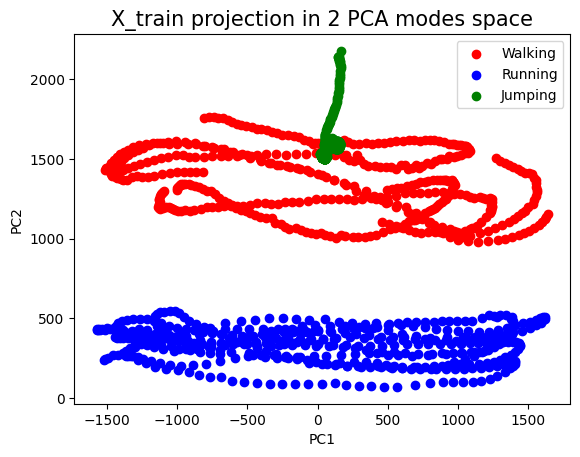

In [131]:
# Truncate the PCA modes to 2 and 3 modes and project X_train in truncated PCA space

# 2 PCA modes projection
X_approx_2 = pca_project(dU_train, X_train, 2)

# Plot the projection
fig3 = plt.figure()
ax3 = plt.axes()
ax3.scatter(X_approx_2[0,0:500], X_approx_2[1,0:500], c = 'r', label = 'Walking')
ax3.scatter(X_approx_2[0,500:1000], X_approx_2[1,500:1000], c = 'b', label = 'Running')
ax3.scatter(X_approx_2[0,1000:1500], X_approx_2[1,1000:1500], c = 'g', label = 'Jumping')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('X_train projection in 2 PCA modes space', fontsize = 15)
fig3.savefig('figure3.pdf', bbox_inches='tight')

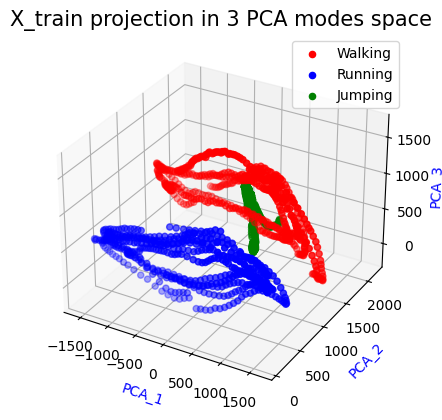

In [135]:
# 3 PCA modes projection
X_approx_3 = pca_project(dU_train, X_train, 3)

# Plot the projection
fig4 = plt.figure()
ax4 = plt.axes(projection='3d')
ax4.scatter(X_approx_3[0,0:500], X_approx_3[1,0:500], X_approx_3[2,0:500], c = 'r', label = 'Walking')
ax4.scatter(X_approx_3[0,500:1000], X_approx_3[1,500:1000], X_approx_3[2,500:1000], c = 'b', label = 'Running')
ax4.scatter(X_approx_3[0,1000:1500], X_approx_3[1,1000:1500], X_approx_3[2,1000:1500], c = 'g', label = 'Jumping')
plt.title('X_train projection in 3 PCA modes space', fontsize = 15)
plt.legend()
ax4.set_xlabel('PCA_1', fontsize=10, labelpad = 4, color = 'blue')
ax4.set_ylabel('PCA_2', fontsize=10, labelpad = 4, color = 'blue')
ax4.set_zlabel('PCA_3', fontsize=10, labelpad = 2, color = 'blue')
fig4.savefig('figure4.pdf', bbox_inches='tight')

In [113]:
# Assign labels to each sample in X_train and X_test
# 0 is walking, 1 is running, 2 is jumping

# Train
Y_true_train = np.zeros(1500)
Y_true_train[500:1000] = 1
Y_true_train[1000:1500] = 2

# Test
Y_true_test = np.zeros(300)
Y_true_test[100:200] = 1
Y_true_test[200:300] = 2

In [102]:
def compute_centroids(X_approx, thres_1, thres_2):
    w = np.mean(X_approx[:,0:thres_1], axis=1).reshape(-1,1)
    r = np.mean(X_approx[:,thres_1:thres_2], axis=1).reshape(-1,1)
    j = np.mean(X_approx[:,thres_2:X_approx.shape[1]], axis=1).reshape(-1,1)
    centroids = np.concatenate((w,r,j), axis = 1)
    return centroids

In [103]:
def label_assign(centroids, point):
    distance = np.zeros(3)
    for i in range(3):
        distance[i] = math.dist(centroids[:, i], point)
    return distance.argmin()

In [105]:
def predict(X_approx, centroids):
    Y_predict = np.zeros(X_approx.shape[1])
    for i in range(X_approx.shape[1]):
        point = X_approx[:, i]
        Y_predict[i] = label_assign(centroids, point)
    return Y_predict

In [117]:
# Calculate accuracy for X_train projections
accuracy_train = []
accuracy_test = []
for i in range(1,15):
    X_approx_train = pca_project(dU, X_train, i)
    X_approx_test = pca_project(dU, X_test, i)
    centroids = compute_centroids(X_approx_train, 500, 1000)
    Y_predict_train = predict(X_approx_train, centroids)
    Y_predict_test = predict(X_approx_test, centroids)
    accuracy_train.append(accuracy_score(Y_true_train, Y_predict_train))
    accuracy_test.append(accuracy_score(Y_true_test, Y_predict_test))

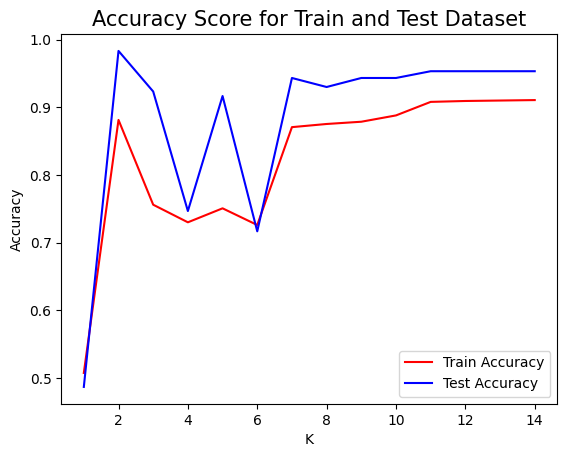

In [138]:
fig5 = plt.figure()
ax5 = plt.axes()
ax5.plot(np.arange(1, 15), accuracy_train, label = 'Train Accuracy', c = 'r')
ax5.plot(np.arange(1, 15), accuracy_test, label = 'Test Accuracy', c = 'b')
plt.legend()
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy Score for Train and Test Dataset', fontsize = 15)
fig5.savefig('figure5.pdf', bbox_inches='tight')

In [169]:
# PCA projection
pca = PCA(n_components = 7)
pca.fit(np.transpose(X_train))
X_approx_train = pca.transform(np.transpose(X_train))
X_approx_test = pca.transform(np.transpose(X_test))

In [176]:
# Random Forest Classification training
from sklearn.ensemble import RandomForestClassifier as RF
clf = RF(n_estimators = 50)
clf = clf.fit(X_approx_train, Y_true_train)
Y_train_RF = clf.predict(X_approx_train)
accuracy_train_RF = accuracy_score(Y_true_train, Y_train_RF)

In [177]:
# Predicting labels using Random Forest Classifier
Y_test_RF = clf.predict(X_approx_test)
accuracy_test_RF = accuracy_score(Y_true_test, Y_test_RF)